# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

- Kalman Filter ([Kalman 1960](https://doi.org/10.1115/1.3662552))
- 3DVar, 4DVar ([Talagrand and Courtier 1987](https://doi.org/10.1002/qj.49711347812))
- Ensemble Kalman Filter([Evensen 1994](https://doi.org/10.1029/94JC00572))
 * ETKF ([Bishop et al. 2001](https://doi.org/10.1175/1520-0493(2001)129%3C0420:ASWTET%3E2.0.CO;2))
 * PO ([Burgers et al. 1998](https://doi.org/10.1175/1520-0493(1998)126%3C1719:ASITEK%3E2.0.CO;2), [Houtekamer et al.2005](https://doi.org/10.1175/MWR-2864.1))
 * EnSRF ([Whitaker and Hamill 2002](https://doi.org/10.1175/1520-0493(2002)130%3C1913:EDAWPO%3E2.0.CO;2))
 * LETKF ([Hunt et al. 2007](https://doi.org/10.1016/j.physd.2006.11.008))
- Maximum Likelihoon Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [2]:
# model parameter
#model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)
nobs = 40 # number of observation (less than or equal to nx)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
infl_parm = 1.2 # multiplicative inflation parameter
lloc = True # localization switch (True=Apply, False=Not apply)
lsig = 8.0 # localization radius
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [5]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
#analysis = Mlef(pt, obs, infl_parm, lsig, linf, lloc, ltlm, model)
analysis = Mlef(pt, obs, infl_parm, lsig, linf, lloc, ltlm)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, infl_parm, lsig, linf, lloc, ltlm, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, infl_parm, linf, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2021-03-10 15:15:15,165 anl INFO operator=linear, sigma=1.0, gamma=3
2021-03-10 15:15:15,304 anl INFO model : model
2021-03-10 15:15:15,304 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.2 lsig=8.0
2021-03-10 15:15:15,305 anl INFO linf=True lloc=True ltlm=True


In [6]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, "nobs":nobs,\
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm,\
    "infl_parm":infl_parm, "lsig":lsig}
func = L96_func(params)

In [7]:
# get truth and make observation
xt, yobs = func.get_true_and_obs()
# initialize all variables
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
 
# analysis-forecast cycle timelot 
# (if analysis is 4-dimensional, analysis is taken every a_window steps.)
a_time = range(0, na, a_window)
e = np.zeros(na) # RMSE between Truth and Analysis
chi = np.zeros(na) # Chi2 test (values are nearly equal to 1 is good)
dof = np.zeros(na) # DOF for signal
for i in a_time:
    # read observation
    yloc = yobs[i:i+a_window,:,0]
    y = yobs[i:i+a_window,:,1]
    # analysis
    if a_window > 1: # assimilate observations at different time (4-dimensional)
        u, pa, ds = analysis(u, pf, y, yloc, cycle=i)
    else: # assimilate observations at a time
        u, pa, innv, chi2, ds = analysis(u, pf, y[0], yloc[0], icycle=i)
    # restore results
    # analysis
    if ft=="ensemble":
        if pt == "mlef" or pt == "grad":
            xa[i] = u[:, 0]
        else:
            xa[i] = np.mean(u, axis=1)
    else:
        xa[i] = u 
    sqrtpa[i] = pa # (mlef) analysis error covariance square root matrix
                   # (other) analysis error covariance matrix
    chi[i] = chi2
    dof[i] = ds
    if i < na-1:
        # forecast
        if a_window > 1: # 4-dimensional
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
        if ft=="ensemble":
            if pt == "mlef" or pt == "grad":
                xf[i+1] = u[:, 0]
            else:
                xf[i+1] = np.mean(u, axis=1)
        else:
            xf[i+1] = u
    # calcurate RMSE and save
    if a_window > 1: # 4-dimensional
        for k in range(i, min(i+a_window,na)):
            e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
    else:
        e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
    

2021-03-10 15:15:19,874 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:19,875 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:19,877 anl INFO eigen value = [581.49878495 336.61960215 220.55112846  96.70170571  86.77785016
  77.19975977  74.09280602  65.71858787  62.24201178  55.63117372
  49.7567674   42.17318982  41.67175951  37.78250918  34.92215711
  32.38492057  30.87078314  27.03263815  25.75796584  24.53808014
  22.02753085  19.88033099  19.28958723  16.87833918  14.67217258
  13.80781111  13.23410373  11.30381845  11.06403297  10.08875777
   9.1296576    7.92334618   7.67284898   6.09157637   5.14899881
   4.80703441   4.56994996   2.93563664   2.31548868   1.60185239]
2021-03-10 15:15:19,878 anl INFO pf - spf@spf.T=-6.375108774214766e-18
2021-03-10 15:15:19,881 anl INFO save_dh=False
2021-03-10 15:15:19,888 anl INFO eigen value =[ 25.75796584  27.03263815  30.87078314  32.38492057  34.92215711
  37.78250918  41.67175951  42.17318982  49.7567674   55.63117372
  62.24201

2021-03-10 15:15:20,108 anl INFO pf - spf@spf.T=-2.2463313761184044e-19
2021-03-10 15:15:20,112 anl INFO save_dh=False
2021-03-10 15:15:20,121 anl INFO eigen value =[0.20203237 0.23600208 0.29578816 0.34533437 0.36214376 0.37737899
 0.40186332 0.50313061 0.56907933 0.58650553 0.6324593  0.66463622
 0.6717248  0.80612836 0.97222214 1.05122119 1.14067838 1.37990455
 1.39180742]
2021-03-10 15:15:20,122 anl INFO save_hist=False
2021-03-10 15:15:20,136 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:20,137 anl INFO J=2.113e+02 dJ=5.437e-15 nit=3
2021-03-10 15:15:20,148 anl INFO eigen value =[0.20203237 0.23600208 0.29578816 0.34533437 0.36214376 0.37737899
 0.40186332 0.50313061 0.56907933 0.58650553 0.6324593  0.66463622
 0.6717248  0.80612836 0.97222214 1.05122119 1.14067838 1.37990455
 1.39180742]
2021-03-10 15:15:20,149 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:20,149 anl INFO d shape=(40,)
2021-03-10 15:15:20,151 anl INFO converge gmat, iter_num

2021-03-10 15:15:20,342 anl INFO J=2.617e+02 dJ=1.289e-14 nit=3
2021-03-10 15:15:20,353 anl INFO eigen value =[0.13145708 0.13799892 0.16386059 0.20585654 0.23503317 0.28466059
 0.28870144 0.30313169 0.35211396 0.38545984 0.39223621 0.43371296
 0.45302038 0.77428456 0.8905056  1.01507478 1.18892943 1.24876141
 1.43742017]
2021-03-10 15:15:20,354 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:20,354 anl INFO d shape=(40,)
2021-03-10 15:15:20,356 anl INFO converge gmat, iter_num=2, norm=4.827878197375476e-06
2021-03-10 15:15:20,357 anl INFO err=1.0846341915797769e-05
2021-03-10 15:15:20,358 anl INFO dof=5.951511054593908
2021-03-10 15:15:20,365 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:20,366 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:20,369 anl INFO eigen value = [1.53036611e+00 1.19607965e+00 1.09523079e+00 1.06401969e+00
 9.28828012e-01 7.51820385e-01 4.30940090e-01 4.15378912e-01
 4.05901728e-01 3.70641604e-01 3.58461255e-01 3.46694914e-01
 2.95063950e-01 2.82423635

2021-03-10 15:15:20,561 anl INFO dof=6.171160989337635
2021-03-10 15:15:20,567 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:20,568 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:20,571 anl INFO eigen value = [1.45228502e+00 1.41068091e+00 1.12961855e+00 1.08121076e+00
 9.80244972e-01 7.00492893e-01 6.73448326e-01 4.97476387e-01
 4.81526240e-01 4.35744820e-01 4.26780142e-01 3.92047350e-01
 3.56220365e-01 2.85997911e-01 2.51896369e-01 2.41536920e-01
 1.57652112e-01 1.09986707e-01 8.02767699e-02 3.01304848e-02
 2.02481380e-02 1.71595515e-02 1.04740761e-02 1.00112821e-02
 8.42249796e-03 8.13563460e-03 6.84134446e-03 4.40506201e-03
 3.40480776e-03 2.83640234e-03 2.60208137e-03 1.88318439e-03
 5.21714987e-04 4.58502282e-04 4.36486105e-04 2.53612648e-04
 1.50842019e-04 1.11772916e-04 9.49837435e-05 2.39101959e-05]
2021-03-10 15:15:20,572 anl INFO pf - spf@spf.T=-1.2296800811764306e-19
2021-03-10 15:15:20,575 anl INFO save_dh=False
2021-03-10 15:15:20,584 anl INFO eigen value =[0.0

2021-03-10 15:15:20,767 anl INFO pf - spf@spf.T=-6.977333317844812e-19
2021-03-10 15:15:20,770 anl INFO save_dh=False
2021-03-10 15:15:20,778 anl INFO eigen value =[0.12848092 0.16709954 0.19516013 0.23080131 0.30446233 0.32502992
 0.40527012 0.45591041 0.48224988 0.52003969 0.54809818 0.63304261
 0.7214294  0.7792689  0.81139499 0.98343123 1.21017881 1.2284506
 1.47114677]
2021-03-10 15:15:20,779 anl INFO save_hist=False
2021-03-10 15:15:20,789 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:20,790 anl INFO J=1.090e+02 dJ=2.122e-15 nit=3
2021-03-10 15:15:20,800 anl INFO eigen value =[0.12848092 0.16709954 0.19516013 0.23080131 0.30446233 0.32502992
 0.40527012 0.45591041 0.48224988 0.52003969 0.54809818 0.63304261
 0.7214294  0.7792689  0.81139499 0.98343123 1.21017881 1.2284506
 1.47114677]
2021-03-10 15:15:20,800 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:20,801 anl INFO d shape=(40,)
2021-03-10 15:15:20,803 anl INFO converge gmat, iter_num=2,

2021-03-10 15:15:20,993 anl INFO J=9.781e+01 dJ=1.213e-14 nit=2
2021-03-10 15:15:21,004 anl INFO eigen value =[0.13394011 0.15637215 0.18858419 0.21822825 0.25053008 0.2600295
 0.26735986 0.27537049 0.41055929 0.4473948  0.47798919 0.60764267
 0.64050495 0.76360009 0.80594083 1.12272105 1.21812627 1.52507504
 1.71786067]
2021-03-10 15:15:21,005 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:21,005 anl INFO d shape=(40,)
2021-03-10 15:15:21,007 anl INFO converge gmat, iter_num=2, norm=6.995514039661587e-06
2021-03-10 15:15:21,008 anl INFO err=2.5953359027411662e-05
2021-03-10 15:15:21,009 anl INFO dof=6.310057540721345
2021-03-10 15:15:21,016 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:21,017 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:21,020 anl INFO eigen value = [1.80069044e+00 1.53990424e+00 1.21603358e+00 1.14309549e+00
 8.11269774e-01 7.16068677e-01 6.72961643e-01 6.04842092e-01
 4.49502868e-01 4.12516788e-01 3.85806605e-01 3.05590254e-01
 2.87341098e-01 2.69477979e

2021-03-10 15:15:21,218 anl INFO dof=6.276109812811368
2021-03-10 15:15:21,224 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:21,224 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:21,228 anl INFO eigen value = [1.40906259e+00 1.27629365e+00 1.05340744e+00 7.64721790e-01
 7.56152431e-01 7.03077460e-01 6.71994849e-01 5.89455388e-01
 5.68207860e-01 4.55258659e-01 4.28861500e-01 3.82004541e-01
 3.32265789e-01 3.05394709e-01 2.87623944e-01 2.69793222e-01
 2.36786882e-01 1.85167021e-01 1.24252504e-01 4.76962668e-02
 3.89682545e-02 2.51640859e-02 1.44520285e-02 1.23448596e-02
 1.22243146e-02 9.42800769e-03 7.38065418e-03 6.05583037e-03
 4.19359085e-03 4.08003724e-03 2.53034780e-03 2.29865901e-03
 1.14286823e-03 9.00872366e-04 6.65799462e-04 4.31643674e-04
 2.86687035e-04 1.60310311e-04 4.80915389e-05 1.66282666e-05]
2021-03-10 15:15:21,229 anl INFO pf - spf@spf.T=7.472524660677437e-20
2021-03-10 15:15:21,232 anl INFO save_dh=False
2021-03-10 15:15:21,241 anl INFO eigen value =[0.124

2021-03-10 15:15:21,430 anl INFO pf - spf@spf.T=2.210523058273229e-19
2021-03-10 15:15:21,433 anl INFO save_dh=False
2021-03-10 15:15:21,442 anl INFO eigen value =[0.18174952 0.24448324 0.2534584  0.25722958 0.29636095 0.32915375
 0.3499058  0.40929941 0.47028124 0.5524207  0.62383949 0.67345262
 0.72627835 0.84702458 0.8959464  0.94552016 1.24639538 1.28484085
 1.33579694]
2021-03-10 15:15:21,443 anl INFO save_hist=False
2021-03-10 15:15:21,452 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:21,453 anl INFO J=7.388e+01 dJ=3.799e-15 nit=3
2021-03-10 15:15:21,492 anl INFO eigen value =[0.18174952 0.24448324 0.2534584  0.25722958 0.29636095 0.32915375
 0.3499058  0.40929941 0.47028124 0.5524207  0.62383949 0.67345262
 0.72627835 0.84702458 0.8959464  0.94552016 1.24639538 1.28484085
 1.33579694]
2021-03-10 15:15:21,493 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:21,493 anl INFO d shape=(40,)
2021-03-10 15:15:21,495 anl INFO converge gmat, iter_num=2

2021-03-10 15:15:21,682 anl INFO J=6.302e+01 dJ=7.470e-15 nit=2
2021-03-10 15:15:21,693 anl INFO eigen value =[0.16353796 0.19328584 0.20231602 0.21075611 0.23320586 0.27626972
 0.28328233 0.33648595 0.35974122 0.44587346 0.62050506 0.73658992
 0.80045989 0.81931419 1.08617057 1.13288794 1.20580987 1.61497165
 1.84387206]
2021-03-10 15:15:21,694 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:21,695 anl INFO d shape=(40,)
2021-03-10 15:15:21,696 anl INFO converge gmat, iter_num=2, norm=8.873091720357398e-06
2021-03-10 15:15:21,698 anl INFO err=2.5441178794124314e-05
2021-03-10 15:15:21,699 anl INFO dof=6.662309771025303
2021-03-10 15:15:21,707 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:21,708 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:21,711 anl INFO eigen value = [1.99595095e+00 1.62105081e+00 1.18486264e+00 1.13137449e+00
 1.09625455e+00 8.50637540e-01 7.61603160e-01 6.72218718e-01
 5.99217313e-01 4.40790959e-01 4.07898472e-01 3.49711732e-01
 3.08001867e-01 2.60940510

2021-03-10 15:15:21,907 anl INFO dof=6.801497969544746
2021-03-10 15:15:21,911 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:21,912 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:21,915 anl INFO eigen value = [1.60923793e+00 1.33043544e+00 1.19202185e+00 1.07584098e+00
 1.02316662e+00 8.17571878e-01 8.05156130e-01 6.77786180e-01
 6.39075614e-01 5.36630561e-01 4.66304410e-01 3.96244470e-01
 3.42917617e-01 2.88151837e-01 2.80089175e-01 2.47332730e-01
 2.17317896e-01 1.88624159e-01 1.52566357e-01 3.29271607e-02
 2.85938308e-02 2.65839650e-02 2.50692159e-02 1.63118099e-02
 1.28612164e-02 1.20758672e-02 1.09444542e-02 3.78426985e-03
 3.45510392e-03 3.34412268e-03 2.70596502e-03 2.33546221e-03
 1.07179378e-03 8.47723835e-04 8.04339996e-04 3.54557684e-04
 2.06147197e-04 1.64579589e-04 8.22038248e-05 3.89396457e-05]
2021-03-10 15:15:21,917 anl INFO pf - spf@spf.T=-8.368939628756663e-19
2021-03-10 15:15:21,919 anl INFO save_dh=False
2021-03-10 15:15:21,928 anl INFO eigen value =[0.15

2021-03-10 15:15:22,119 anl INFO pf - spf@spf.T=-1.8111681994665076e-19
2021-03-10 15:15:22,122 anl INFO save_dh=False
2021-03-10 15:15:22,131 anl INFO eigen value =[0.16927616 0.21818831 0.22418328 0.24167349 0.26120622 0.29052567
 0.32823712 0.34775532 0.3850605  0.48430199 0.53526347 0.71303108
 0.76216878 0.81504937 0.85241489 0.90097905 1.01760618 1.22172632
 1.45705579]
2021-03-10 15:15:22,131 anl INFO save_hist=False
2021-03-10 15:15:22,142 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:22,142 anl INFO J=5.568e+01 dJ=2.706e-15 nit=3
2021-03-10 15:15:22,152 anl INFO eigen value =[0.16927616 0.21818831 0.22418328 0.24167349 0.26120622 0.29052567
 0.32823712 0.34775532 0.3850605  0.48430199 0.53526347 0.71303108
 0.76216878 0.81504937 0.85241489 0.90097905 1.01760618 1.22172632
 1.45705579]
2021-03-10 15:15:22,153 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:22,154 anl INFO d shape=(40,)
2021-03-10 15:15:22,155 anl INFO converge gmat, iter_num

2021-03-10 15:15:22,346 anl INFO J=6.072e+01 dJ=2.912e-15 nit=3
2021-03-10 15:15:22,355 anl INFO eigen value =[0.12955547 0.18397361 0.20529198 0.22714867 0.24126035 0.26729405
 0.2833672  0.36919132 0.49810037 0.5145257  0.5709459  0.76681406
 0.78447627 0.82523173 0.90031158 0.98138256 1.36988672 1.46791794
 1.78326094]
2021-03-10 15:15:22,356 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:22,357 anl INFO d shape=(40,)
2021-03-10 15:15:22,359 anl INFO converge gmat, iter_num=2, norm=8.057111552376537e-06
2021-03-10 15:15:22,360 anl INFO err=2.0942923890278657e-05
2021-03-10 15:15:22,361 anl INFO dof=6.665259062749567
2021-03-10 15:15:22,367 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:22,367 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:22,371 anl INFO eigen value = [1.63832228e+00 1.52018912e+00 1.38404235e+00 1.00965374e+00
 9.65344708e-01 8.59150765e-01 7.30032648e-01 5.94332956e-01
 5.10207825e-01 5.05246675e-01 4.07857185e-01 3.36405408e-01
 2.86270606e-01 2.60707360

2021-03-10 15:15:22,563 anl INFO dof=6.216705714162278
2021-03-10 15:15:22,570 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:22,570 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:22,574 anl INFO eigen value = [1.21006749e+00 1.13380010e+00 1.01028561e+00 9.78821409e-01
 7.15771353e-01 6.57609373e-01 6.31492638e-01 6.09253569e-01
 5.68226180e-01 5.54939263e-01 4.92577684e-01 3.70935336e-01
 3.16004829e-01 2.66960270e-01 2.38968769e-01 1.83658995e-01
 1.76286578e-01 1.38899746e-01 7.74240117e-02 4.06621665e-02
 3.26483369e-02 2.53116203e-02 2.26209022e-02 1.38258774e-02
 1.32227425e-02 1.04083568e-02 6.97771434e-03 5.68536648e-03
 5.05439545e-03 4.21925879e-03 2.66697826e-03 1.97184114e-03
 1.58161339e-03 1.01390082e-03 8.63492614e-04 4.02568323e-04
 2.63174220e-04 2.34554207e-04 1.58821903e-04 1.55409696e-05]
2021-03-10 15:15:22,575 anl INFO pf - spf@spf.T=3.344509592233605e-20
2021-03-10 15:15:22,578 anl INFO save_dh=False
2021-03-10 15:15:22,587 anl INFO eigen value =[0.077

2021-03-10 15:15:22,782 anl INFO pf - spf@spf.T=-1.2451384324638215e-21
2021-03-10 15:15:22,785 anl INFO save_dh=False
2021-03-10 15:15:22,794 anl INFO eigen value =[0.12752372 0.14690123 0.17427831 0.18344505 0.22813337 0.31070303
 0.36778567 0.38599737 0.40291678 0.44065767 0.46324194 0.57427942
 0.59164465 0.62319603 0.72630783 0.80523085 1.06203423 1.21495172
 1.5595275 ]
2021-03-10 15:15:22,795 anl INFO save_hist=False
2021-03-10 15:15:22,806 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:22,806 anl INFO J=3.571e+01 dJ=1.866e-15 nit=3
2021-03-10 15:15:22,816 anl INFO eigen value =[0.12752372 0.14690123 0.17427831 0.18344505 0.22813337 0.31070303
 0.36778567 0.38599737 0.40291678 0.44065767 0.46324194 0.57427942
 0.59164465 0.62319603 0.72630783 0.80523085 1.06203423 1.21495172
 1.5595275 ]
2021-03-10 15:15:22,817 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:22,817 anl INFO d shape=(40,)
2021-03-10 15:15:22,819 anl INFO converge gmat, iter_num

2021-03-10 15:15:22,999 anl INFO J=2.057e+01 dJ=5.319e-15 nit=2
2021-03-10 15:15:23,009 anl INFO eigen value =[0.09844057 0.13081413 0.14826036 0.16887859 0.18076697 0.25413154
 0.31610868 0.33711641 0.35271458 0.40292278 0.49680771 0.56388842
 0.65024984 0.67319223 0.98581677 1.02216095 1.06013702 1.39741308
 1.75465088]
2021-03-10 15:15:23,010 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:23,011 anl INFO d shape=(40,)
2021-03-10 15:15:23,012 anl INFO converge gmat, iter_num=2, norm=6.192809716525761e-06
2021-03-10 15:15:23,013 anl INFO err=2.1684818957499503e-05
2021-03-10 15:15:23,015 anl INFO dof=6.100095114357125
2021-03-10 15:15:23,022 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:23,023 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:23,026 anl INFO eigen value = [1.91969605e+00 1.38404947e+00 1.12579315e+00 1.04427770e+00
 9.65994804e-01 6.08132143e-01 5.92765288e-01 5.83661488e-01
 4.68883010e-01 4.26288710e-01 3.73892522e-01 3.14234445e-01
 2.97728909e-01 2.70525677

2021-03-10 15:15:23,212 anl INFO dof=5.970513099688111
2021-03-10 15:15:23,218 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:23,218 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:23,222 anl INFO eigen value = [1.35577028e+00 1.31615561e+00 1.20343814e+00 9.63317611e-01
 7.91290710e-01 7.64130378e-01 5.37915125e-01 4.51268725e-01
 4.38693329e-01 3.79148440e-01 3.56396809e-01 3.31609071e-01
 3.04279052e-01 2.63421694e-01 2.29782904e-01 1.65711675e-01
 1.58851299e-01 1.48680074e-01 1.17564139e-01 4.39186750e-02
 3.93975437e-02 1.60686684e-02 1.42614522e-02 1.04621232e-02
 9.08279722e-03 8.54166886e-03 5.49169583e-03 4.52384218e-03
 3.41131475e-03 3.28522132e-03 1.90525863e-03 1.74027692e-03
 1.18757004e-03 6.95591030e-04 4.82454853e-04 4.10765886e-04
 1.80233788e-04 1.07956857e-04 4.78547949e-05 3.51074195e-05]
2021-03-10 15:15:23,223 anl INFO pf - spf@spf.T=-4.0858592974501704e-19
2021-03-10 15:15:23,226 anl INFO save_dh=False
2021-03-10 15:15:23,234 anl INFO eigen value =[0.1

2021-03-10 15:15:23,415 anl INFO pf - spf@spf.T=2.1163435824503914e-19
2021-03-10 15:15:23,418 anl INFO save_dh=False
2021-03-10 15:15:23,427 anl INFO eigen value =[0.11536885 0.11791539 0.19809096 0.21125809 0.21658273 0.251789
 0.28259365 0.38914619 0.42186022 0.42773532 0.47606652 0.52793148
 0.61362691 0.68363261 0.70760185 0.9954362  1.0266243  1.21039489
 1.51352319]
2021-03-10 15:15:23,428 anl INFO save_hist=False
2021-03-10 15:15:23,436 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:23,437 anl INFO J=2.203e+01 dJ=6.412e-15 nit=2
2021-03-10 15:15:23,446 anl INFO eigen value =[0.11536885 0.11791539 0.19809096 0.21125809 0.21658273 0.251789
 0.28259365 0.38914619 0.42186022 0.42773532 0.47606652 0.52793148
 0.61362691 0.68363261 0.70760185 0.9954362  1.0266243  1.21039489
 1.51352319]
2021-03-10 15:15:23,447 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:23,447 anl INFO d shape=(40,)
2021-03-10 15:15:23,449 anl INFO converge gmat, iter_num=2, n

2021-03-10 15:15:23,641 anl INFO eigen value =[0.13177946 0.1495157  0.18897823 0.24558158 0.25414676 0.2940461
 0.32723211 0.33082001 0.39346829 0.41256719 0.45615131 0.46991092
 0.52370106 0.69767321 0.93755908 1.09168532 1.10396624 1.19873476
 1.62179538]
2021-03-10 15:15:23,641 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:23,642 anl INFO d shape=(40,)
2021-03-10 15:15:23,644 anl INFO converge gmat, iter_num=2, norm=5.4141046501105676e-06
2021-03-10 15:15:23,645 anl INFO err=7.714015277720662e-06
2021-03-10 15:15:23,647 anl INFO dof=6.183946309732594
2021-03-10 15:15:23,654 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:23,655 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:23,657 anl INFO eigen value = [1.55926609e+00 1.18985339e+00 1.15901816e+00 1.05574310e+00
 8.70387831e-01 7.78521615e-01 4.84783545e-01 4.45405309e-01
 4.26463054e-01 4.10516212e-01 3.57832609e-01 3.29565852e-01
 3.02447746e-01 2.70804656e-01 2.55161542e-01 2.51796865e-01
 1.92568816e-01 1.40200602e-01

2021-03-10 15:15:23,854 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:23,855 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:23,857 anl INFO eigen value = [1.10912875e+00 1.07024890e+00 8.96417046e-01 7.88895677e-01
 7.50508270e-01 6.93817023e-01 5.74941312e-01 5.43134509e-01
 5.00502153e-01 4.74258197e-01 4.39788018e-01 3.63943740e-01
 3.19762693e-01 2.92948077e-01 2.11416906e-01 1.88261743e-01
 1.75152374e-01 1.71494898e-01 1.20744078e-01 3.14265937e-02
 2.51925258e-02 1.56488366e-02 1.51298773e-02 1.43635820e-02
 1.19376384e-02 1.04769260e-02 7.23027351e-03 5.49382022e-03
 5.08302315e-03 3.41063169e-03 2.26967968e-03 1.44287528e-03
 1.04079703e-03 6.79344174e-04 5.64234146e-04 4.37830815e-04
 2.09276700e-04 1.58349843e-04 7.08857441e-05 4.20437352e-05]
2021-03-10 15:15:23,858 anl INFO pf - spf@spf.T=-2.4404925034527715e-19
2021-03-10 15:15:23,862 anl INFO save_dh=False
2021-03-10 15:15:23,870 anl INFO eigen value =[0.12074408 0.1714949  0.17515237 0.18826174 0.21141691 0.2

2021-03-10 15:15:24,050 anl INFO pf - spf@spf.T=-6.939952695091297e-20
2021-03-10 15:15:24,052 anl INFO save_dh=False
2021-03-10 15:15:24,061 anl INFO eigen value =[0.13683646 0.15094602 0.16883567 0.18012126 0.19278743 0.3005917
 0.3192306  0.32123248 0.3560358  0.37742754 0.38600617 0.57450888
 0.62753094 0.73936546 0.78872361 0.8849141  0.94833229 1.29814547
 1.42217767]
2021-03-10 15:15:24,062 anl INFO save_hist=False
2021-03-10 15:15:24,070 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:24,071 anl INFO J=1.684e+01 dJ=3.401e-15 nit=2
2021-03-10 15:15:24,081 anl INFO eigen value =[0.13683646 0.15094602 0.16883567 0.18012126 0.19278743 0.3005917
 0.3192306  0.32123248 0.3560358  0.37742754 0.38600617 0.57450888
 0.62753094 0.73936546 0.78872361 0.8849141  0.94833229 1.29814547
 1.42217767]
2021-03-10 15:15:24,082 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:24,083 anl INFO d shape=(40,)
2021-03-10 15:15:24,085 anl INFO converge gmat, iter_num=2,

2021-03-10 15:15:24,265 anl INFO J=1.600e+01 dJ=3.873e-15 nit=2
2021-03-10 15:15:24,276 anl INFO eigen value =[0.0714125  0.16677665 0.1933476  0.20325623 0.27210045 0.28939418
 0.30098873 0.35051355 0.45539125 0.47599167 0.55206818 0.64373914
 0.69388307 0.76114697 0.82301645 0.95257912 0.99165941 1.08532424
 1.13809807]
2021-03-10 15:15:24,277 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:24,278 anl INFO d shape=(40,)
2021-03-10 15:15:24,279 anl INFO converge gmat, iter_num=2, norm=3.5684490122932618e-06
2021-03-10 15:15:24,281 anl INFO err=1.3421937109683015e-06
2021-03-10 15:15:24,282 anl INFO dof=6.1842903659850235
2021-03-10 15:15:24,289 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:24,290 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:24,293 anl INFO eigen value = [1.14514404e+00 1.13879739e+00 9.14638776e-01 8.80551927e-01
 8.01249711e-01 7.27075099e-01 7.07410818e-01 6.28849494e-01
 5.72656395e-01 4.48398467e-01 4.35771474e-01 3.66363209e-01
 3.09709926e-01 2.768321

2021-03-10 15:15:24,475 anl INFO err=3.3705795145508615e-06
2021-03-10 15:15:24,476 anl INFO dof=6.446470578887299
2021-03-10 15:15:24,485 anl INFO ==inflation==, alpha=1.2
2021-03-10 15:15:24,486 anl INFO ==localization==, lsig=8.0
2021-03-10 15:15:24,490 anl INFO eigen value = [1.20748586e+00 1.18649165e+00 1.09892023e+00 1.05385363e+00
 9.22422281e-01 8.36033811e-01 7.80433092e-01 6.42549830e-01
 5.18751513e-01 4.47039888e-01 4.38511715e-01 3.84890408e-01
 3.43389434e-01 3.18291138e-01 2.67412782e-01 2.61885231e-01
 2.25197676e-01 2.04816835e-01 9.84368150e-02 3.93659404e-02
 2.65539143e-02 1.38154116e-02 1.22548829e-02 1.13918202e-02
 8.43647519e-03 6.90801425e-03 6.01070200e-03 4.72844404e-03
 4.41489659e-03 3.62665342e-03 3.03893465e-03 2.04104176e-03
 1.59076011e-03 1.27457243e-03 1.14570611e-03 5.46509736e-04
 3.58211448e-04 2.37713534e-04 1.84824370e-04 1.71094308e-04]
2021-03-10 15:15:24,491 anl INFO pf - spf@spf.T=-1.5255698654760389e-19
2021-03-10 15:15:24,495 anl INFO save

2021-03-10 15:15:24,681 anl INFO pf - spf@spf.T=2.8360568898205297e-19
2021-03-10 15:15:24,683 anl INFO save_dh=False
2021-03-10 15:15:24,692 anl INFO eigen value =[0.09468794 0.14439859 0.17569386 0.2159296  0.25267669 0.31972504
 0.35960194 0.36950446 0.41653268 0.43839534 0.58761157 0.66516753
 0.67891664 0.76114075 0.83868325 1.02909629 1.03913459 1.16468957
 1.36376869]
2021-03-10 15:15:24,693 anl INFO save_hist=False
2021-03-10 15:15:24,703 anl INFO success=True message=Optimization terminated successfully.
2021-03-10 15:15:24,704 anl INFO J=1.562e+01 dJ=1.380e-15 nit=3
2021-03-10 15:15:24,713 anl INFO eigen value =[0.09468794 0.14439859 0.17569386 0.2159296  0.25267669 0.31972504
 0.35960194 0.36950446 0.41653268 0.43839534 0.58761157 0.66516753
 0.67891664 0.76114075 0.83868325 1.02909629 1.03913459 1.16468957
 1.36376869]
2021-03-10 15:15:24,714 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:24,714 anl INFO d shape=(40,)
2021-03-10 15:15:24,716 anl INFO converge gmat, iter_num=

2021-03-10 15:15:24,896 anl INFO J=1.747e+01 dJ=3.477e-15 nit=2
2021-03-10 15:15:24,907 anl INFO eigen value =[0.08882445 0.11458866 0.14777071 0.19465926 0.21770201 0.26589613
 0.27014178 0.34430356 0.36242887 0.41859095 0.44711407 0.52605307
 0.67750334 0.69945354 0.72265178 0.87670615 0.96211455 1.06387164
 1.27543928]
2021-03-10 15:15:24,908 anl INFO zmat shape=(40, 19)
2021-03-10 15:15:24,909 anl INFO d shape=(40,)
2021-03-10 15:15:24,911 anl INFO converge gmat, iter_num=2, norm=3.205867268734067e-06
2021-03-10 15:15:24,912 anl INFO err=1.5269941428711125e-06
2021-03-10 15:15:24,913 anl INFO dof=5.81692971280951


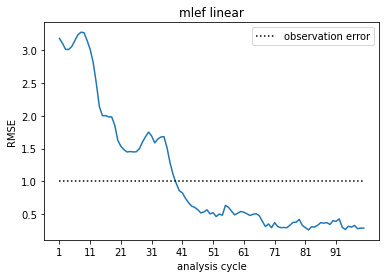

In [8]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()